In [1]:
import numpy as np
from datasets import Dataset, DatasetDict
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from transformers import Trainer, TrainingArguments
import pandas as pd
import torch

2025-02-27 00:55:16.061405: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740610516.083284  557354 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740610516.090011  557354 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-27 00:55:16.112684: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the CSV files into DataFrames
df1 = pd.read_csv('all_text_features.csv')
df2 = pd.read_csv('all_audio_features.csv')
df3 = pd.read_csv('all_video_features.csv')

# Merge the DataFrames on 'row_id' and 'clip_id'
text_audio_merged_df = pd.merge(df1, df2, on=['video_id', 'clip_id', 'mode', 'annotation_label'], how='inner')
audio_video_merged_df = pd.merge(df3, df2, on=['video_id', 'clip_id', 'mode', 'annotation_label'], how='inner')
text_video_merged_df = pd.merge(df3, df1, on=['video_id', 'clip_id', 'mode', 'annotation_label'], how='inner')
all_merged_df = pd.merge(text_audio_merged_df, df3, on=['video_id', 'clip_id', 'mode', 'annotation_label'], how='inner')

In [3]:
all_merged_df

,video_id,clip_id,mode,annotation_label,text_feature_0,text_feature_1,text_feature_2,text_feature_3,text_feature_4,text_feature_5,...,video_feature_758,video_feature_759,video_feature_760,video_feature_761,video_feature_762,video_feature_763,video_feature_764,video_feature_765,video_feature_766,video_feature_767
0,03bSnISJMiM,11,train,0.0,0.270479,0.996873,-0.641382,-0.476987,0.186320,-0.479807,...,-1.078334,-0.212412,-0.014572,-0.375293,0.837917,0.062687,-0.597331,-0.259640,-1.898719,-1.712027
1,03bSnISJMiM,10,train,0.0,0.004698,0.782621,-0.380408,-0.298272,0.170435,-1.098768,...,-1.147198,0.130909,-0.206098,0.206220,0.948254,0.354763,-0.502355,-0.444589,-1.971562,-1.491572
2,03bSnISJMiM,13,train,1.0,-0.173633,0.156800,-0.037979,-0.099305,0.478109,0.384305,...,-0.516917,-0.099885,0.251831,-0.179767,0.371510,0.690991,-0.825537,-0.097008,-1.760048,-0.853008
3,03bSnISJMiM,12,train,1.0,-0.218314,0.158072,0.014531,-0.098467,0.774070,0.201158,...,-1.019300,0.115281,-0.440721,0.511699,0.359596,0.243479,-0.542120,-0.339106,-1.352056,-1.143122
4,03bSnISJMiM,1,train,1.0,0.010284,1.077508,-0.288741,-0.307522,0.177738,-1.068847,...,-1.380751,0.155880,-0.150362,0.494003,-0.353426,0.795431,-0.958967,-0.645879,-1.676601,-0.627469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2194,zhpQhgha_KU,30,test,0.0,-0.049752,0.957713,-0.359034,-0.270461,0.229189,-0.694572,...,-0.228938,0.320100,-0.162853,0.810133,0.515550,-0.156523,0.345616,-0.714201,-0.877672,-0.311081
2195,zhpQhgha_KU,35,test,1.0,-0.280185,0.325935,0.116856,-0.097485,0.463279,0.388187,...,-0.746198,0.073125,-0.412568,0.249044,-0.190793,-0.707994,0.889685,-0.609933,-0.753124,-0.484004
2196,zhpQhgha_KU,34,test,1.0,-0.269441,0.182711,0.016000,-0.244879,0.844845,0.338559,...,-1.035848,0.008247,-0.900263,0.018754,0.038172,-0.237460,0.659862,-1.022472,-0.690134,-0.631602
2197,zhpQhgha_KU,33,test,0.0,0.085537,0.797328,-0.684733,-0.682357,0.026557,-1.482874,...,-0.822525,0.197105,-1.279548,1.058336,0.070369,-0.570976,0.977215,-0.469761,-0.729410,-0.640767


In [4]:
all_merged_df.shape

(2199, 1796)

In [5]:
text_video_merged_df

,video_id,clip_id,annotation_label,mode,video_feature_0,video_feature_1,video_feature_2,video_feature_3,video_feature_4,video_feature_5,...,text_feature_758,text_feature_759,text_feature_760,text_feature_761,text_feature_762,text_feature_763,text_feature_764,text_feature_765,text_feature_766,text_feature_767
0,03bSnISJMiM,11,0.0,train,0.439371,0.247791,0.068513,-0.060806,-0.017575,1.074164,...,0.175551,-0.400694,1.523944,-0.462501,-0.536807,-0.280624,-1.016937,1.423308,-0.587316,0.493037
1,03bSnISJMiM,10,0.0,train,0.522580,-0.117958,0.194243,-0.449619,0.201808,0.718872,...,0.017866,-0.578022,1.223537,-0.693100,-0.596493,-0.669539,-1.417102,1.755622,-0.696475,-0.198517
2,03bSnISJMiM,13,1.0,train,0.552831,-0.262263,-0.262357,-0.497176,-0.030941,0.890128,...,-0.491156,0.374492,-0.868094,0.546483,0.346713,0.978013,1.077066,-1.140594,0.285355,-0.503165
3,03bSnISJMiM,12,1.0,train,0.857708,-0.255024,-0.243093,-0.587603,0.491963,0.778350,...,-0.324607,0.427225,-0.949620,0.890572,0.344190,0.990553,1.096355,-1.344340,0.151529,-0.253343
4,03bSnISJMiM,1,1.0,train,1.157361,-0.556899,-0.445768,-0.851537,-0.388610,1.048423,...,0.024403,-0.370995,1.370107,-0.694416,-0.878269,-0.539672,-1.410939,1.602672,-0.701200,-0.343756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2194,zhpQhgha_KU,30,0.0,test,0.831355,0.805724,-0.272573,-0.342349,0.830707,0.128523,...,0.024912,-0.390740,1.362876,-0.757794,-0.340896,-0.683082,-1.307081,1.482841,-0.424735,0.166160
2195,zhpQhgha_KU,35,1.0,test,0.406417,-0.202951,-0.464274,-0.611844,0.705797,1.094925,...,-0.416712,0.185422,-0.952263,0.721526,0.317901,0.984032,1.297174,-1.270689,0.028467,-0.285608
2196,zhpQhgha_KU,34,1.0,test,0.376954,0.443066,-0.704081,-1.114472,0.345048,0.574175,...,-0.428979,0.406420,-0.686308,0.709681,0.371721,1.014873,1.001999,-1.066811,0.325641,-0.397676
2197,zhpQhgha_KU,33,0.0,test,0.971935,-0.153978,-0.714686,-0.591438,0.880721,1.153031,...,0.458958,-0.124651,1.233465,-0.427328,-0.985934,-0.367509,-0.899962,1.758477,-0.711113,0.246065


In [6]:
# merged_df.to_csv('all_features.csv', index=False)

In [7]:
# Filter the DataFrame by mode (train, valid, test) to create subsets
train_all_merged_df = all_merged_df[all_merged_df["mode"] == "train"].drop(columns=["mode"])
train_text_audio_merged_df = text_audio_merged_df[text_audio_merged_df["mode"] == "train"].drop(columns=["mode"])
train_audio_video_merged_df = audio_video_merged_df[audio_video_merged_df["mode"] == "train"].drop(columns=["mode"])
train_text_video_merged_df = text_video_merged_df[text_video_merged_df["mode"] == "train"].drop(columns=["mode"])

valid_all_merged_df = all_merged_df[all_merged_df["mode"] == "valid"].drop(columns=["mode"])
valid_text_audio_merged_df = text_audio_merged_df[text_audio_merged_df["mode"] == "valid"].drop(columns=["mode"])
valid_audio_video_merged_df = audio_video_merged_df[audio_video_merged_df["mode"] == "valid"].drop(columns=["mode"])
valid_text_video_merged_df = text_video_merged_df[text_video_merged_df["mode"] == "valid"].drop(columns=["mode"])

test_all_merged_df = all_merged_df[all_merged_df["mode"] == "test"].drop(columns=["mode"])
test_text_audio_merged_df = text_audio_merged_df[text_audio_merged_df["mode"] == "test"].drop(columns=["mode"])
test_audio_video_merged_df = audio_video_merged_df[audio_video_merged_df["mode"] == "test"].drop(columns=["mode"])
test_text_video_merged_df = text_video_merged_df[text_video_merged_df["mode"] == "test"].drop(columns=["mode"])

In [8]:
train_all_merged_df

,video_id,clip_id,annotation_label,text_feature_0,text_feature_1,text_feature_2,text_feature_3,text_feature_4,text_feature_5,text_feature_6,...,video_feature_758,video_feature_759,video_feature_760,video_feature_761,video_feature_762,video_feature_763,video_feature_764,video_feature_765,video_feature_766,video_feature_767
0,03bSnISJMiM,11,0.0,0.270479,0.996873,-0.641382,-0.476987,0.186320,-0.479807,0.271487,...,-1.078334,-0.212412,-0.014572,-0.375293,0.837917,0.062687,-0.597331,-0.259640,-1.898719,-1.712027
1,03bSnISJMiM,10,0.0,0.004698,0.782621,-0.380408,-0.298272,0.170435,-1.098768,-0.181759,...,-1.147198,0.130909,-0.206098,0.206220,0.948254,0.354763,-0.502355,-0.444589,-1.971562,-1.491572
2,03bSnISJMiM,13,1.0,-0.173633,0.156800,-0.037979,-0.099305,0.478109,0.384305,-0.058273,...,-0.516917,-0.099885,0.251831,-0.179767,0.371510,0.690991,-0.825537,-0.097008,-1.760048,-0.853008
3,03bSnISJMiM,12,1.0,-0.218314,0.158072,0.014531,-0.098467,0.774070,0.201158,-0.369480,...,-1.019300,0.115281,-0.440721,0.511699,0.359596,0.243479,-0.542120,-0.339106,-1.352056,-1.143122
4,03bSnISJMiM,1,1.0,0.010284,1.077508,-0.288741,-0.307522,0.177738,-1.068847,-0.060524,...,-1.380751,0.155880,-0.150362,0.494003,-0.353426,0.795431,-0.958967,-0.645879,-1.676601,-0.627469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1279,W8NXH0Djyww,19,0.0,0.072391,0.765663,-0.559932,-0.240193,0.214473,-0.933237,0.202434,...,-1.049781,-0.097843,0.535710,-0.125911,-0.487650,0.725425,-0.131264,-0.814491,-0.474926,0.298997
1280,W8NXH0Djyww,18,1.0,-0.273359,0.135727,0.261043,-0.124110,0.093434,0.186650,-0.098025,...,0.653575,-0.126224,0.412706,0.129997,0.412914,0.953175,-0.251088,-1.235145,-0.170783,0.061585
1281,W8NXH0Djyww,31,1.0,-0.080533,0.820012,-0.512017,-0.286724,0.177884,-1.070902,0.127666,...,0.549700,-0.191364,0.192096,0.050092,0.258074,1.061694,-0.261101,-1.281922,-0.064462,0.194249
1282,W8NXH0Djyww,30,0.0,-0.373313,0.167305,0.324999,-0.059186,0.566811,0.230739,-0.142146,...,1.057948,-0.183860,-0.168658,0.065459,0.757941,0.713041,-0.255165,-1.426317,-0.134659,0.208903


In [9]:
test_text_video_merged_df

,video_id,clip_id,annotation_label,video_feature_0,video_feature_1,video_feature_2,video_feature_3,video_feature_4,video_feature_5,video_feature_6,...,text_feature_758,text_feature_759,text_feature_760,text_feature_761,text_feature_762,text_feature_763,text_feature_764,text_feature_765,text_feature_766,text_feature_767
1513,c7UH_rxdZv4,24,0.0,0.616361,0.415739,-0.622293,-1.296277,-0.342991,1.564045,0.258472,...,0.193118,-0.486089,1.392372,-0.696001,-0.810331,-0.345925,-1.391639,1.704905,-0.736086,0.248847
1514,c7UH_rxdZv4,25,1.0,0.353537,-0.232666,-0.457549,-1.478246,-0.349484,0.918699,-0.108954,...,-0.440732,0.417015,-0.851555,0.758757,0.419784,1.020385,1.154922,-0.931525,0.181172,-0.477168
1515,c7UH_rxdZv4,26,0.0,0.226897,1.027227,-0.809006,-0.476973,-0.843320,1.732117,0.456953,...,-0.243117,-0.739573,1.273095,-0.803861,-0.729338,-0.636050,-1.187549,1.671630,-0.736085,-0.493479
1516,c7UH_rxdZv4,27,0.0,0.349119,0.775047,-0.422119,-0.604920,-0.460934,1.797762,0.439652,...,0.011160,-0.791038,1.196986,-0.641667,-0.666448,-0.845131,-0.939244,1.476472,-0.536616,-0.060048
1517,c7UH_rxdZv4,20,0.0,-0.108904,0.677407,-0.420910,-0.962616,-0.487292,2.155302,0.432271,...,0.026676,-0.502513,1.491710,-0.818012,-0.760336,-0.499871,-1.255345,1.668507,-0.587110,0.205102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2194,zhpQhgha_KU,30,0.0,0.831355,0.805724,-0.272573,-0.342349,0.830707,0.128523,1.396225,...,0.024912,-0.390740,1.362876,-0.757794,-0.340896,-0.683082,-1.307081,1.482841,-0.424735,0.166160
2195,zhpQhgha_KU,35,1.0,0.406417,-0.202951,-0.464274,-0.611844,0.705797,1.094925,0.821598,...,-0.416712,0.185422,-0.952263,0.721526,0.317901,0.984032,1.297174,-1.270689,0.028467,-0.285608
2196,zhpQhgha_KU,34,1.0,0.376954,0.443066,-0.704081,-1.114472,0.345048,0.574175,1.111698,...,-0.428979,0.406420,-0.686308,0.709681,0.371721,1.014873,1.001999,-1.066811,0.325641,-0.397676
2197,zhpQhgha_KU,33,0.0,0.971935,-0.153978,-0.714686,-0.591438,0.880721,1.153031,1.294981,...,0.458958,-0.124651,1.233465,-0.427328,-0.985934,-0.367509,-0.899962,1.758477,-0.711113,0.246065


---
# Trimodal

In [10]:
# from sklearn.preprocessing import StandardScaler

# # Normalize features
# scaler = StandardScaler()

In [11]:
train_all_merged_labels = train_all_merged_df['annotation_label']
train_all_merged_features = train_all_merged_df.drop(columns=['video_id', 'clip_id', 'annotation_label'])
train_all_merged_features = train_all_merged_features.values.tolist()
# Create datasets with the features and labels
train_all_merged_dataset = Dataset.from_dict({
    'input_ids': train_all_merged_features,
    'labels': train_all_merged_labels.tolist(),
    'clip_id': train_all_merged_df['clip_id'].tolist(),
    'video_id': train_all_merged_df['video_id'].tolist()
})

In [12]:
valid_all_merged_labels = valid_all_merged_df['annotation_label']
valid_all_merged_features = valid_all_merged_df.drop(columns=['video_id', 'clip_id', 'annotation_label'])
valid_all_merged_features = valid_all_merged_features.values.tolist()
# Create datasets with the features and labels
valid_all_merged_dataset = Dataset.from_dict({
    'input_ids': valid_all_merged_features,
    'labels': valid_all_merged_labels.tolist(),
    'clip_id': valid_all_merged_df['clip_id'].tolist(),
    'video_id': valid_all_merged_df['video_id'].tolist()
})

In [13]:
test_all_merged_labels = test_all_merged_df['annotation_label']
test_all_merged_features = test_all_merged_df.drop(columns=['video_id', 'clip_id', 'annotation_label'])
test_all_merged_features = test_all_merged_features.values.tolist()
# Create datasets with the features and labels
test_all_merged_dataset = Dataset.from_dict({
    'input_ids': test_all_merged_features,
    'labels': test_all_merged_labels.tolist(),
    'clip_id': test_all_merged_df['clip_id'].tolist(),
    'video_id': test_all_merged_df['video_id'].tolist()
})

In [14]:
# Create the DatasetDict to hold the subsets
dataset_all_merged = DatasetDict({
    'train': train_all_merged_dataset,
    'valid': valid_all_merged_dataset,
    'test': test_all_merged_dataset
})

In [15]:
dataset_all_merged

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels', 'clip_id', 'video_id'],
        num_rows: 1284
    })
    valid: Dataset({
        features: ['input_ids', 'labels', 'clip_id', 'video_id'],
        num_rows: 229
    })
    test: Dataset({
        features: ['input_ids', 'labels', 'clip_id', 'video_id'],
        num_rows: 686
    })
})

In [16]:
class MLP_Model(nn.Module):
    def __init__(self, layer_sizes, output_dim=2, dropout_p=0, act_func="tanh"):
        super(MLP_Model, self).__init__()
        self.layer_sizes = layer_sizes
        self.output_dim = output_dim
        self.dropout_prob = dropout_p

        # Create a list to hold all layers
        self.layers = nn.ModuleList()

        # Input layer normalization
        # self.layer_norm1 = nn.LayerNorm(layer_sizes[0])

        # Add the first layer
        self.layers.append(nn.Linear(layer_sizes[0], layer_sizes[1]))

        # Add intermediate layers
        for i in range(1, len(layer_sizes) - 1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))

        # Output layer
        self.out = nn.Linear(layer_sizes[-1], output_dim)

        # Dropout and activation
        self.dropout = nn.Dropout(dropout_p)
        if act_func == "tanh":
            self.act = nn.Tanh()
        elif act_func == "relu":
            self.act = nn.ReLU()

    def forward(self, x, labels=None):
        # Apply LayerNorm to the input
        # x = self.layer_norm1(x)

        # Pass through all layers
        for layer in self.layers:
            x = layer(x)
            x = self.act(x)
            x = self.dropout(x)

        # Output layer
        x = self.out(x)
        return x

In [17]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    # Convert lists to tensors
    input_ids = torch.tensor([item['input_ids'] for item in batch], dtype=torch.float32)
    labels = torch.tensor([item['labels'] for item in batch], dtype=torch.long)
    video_ids = [item['video_id'] for item in batch]  # Store video_id
    clip_ids = [item['clip_id'] for item in batch]  # Store clip_id

    return {'input_ids': input_ids,
            'labels': labels,
            'video_id': video_ids,
            'clip_id': clip_ids}

# Convert datasets to DataLoaders
train_all_loader = DataLoader(dataset_all_merged['train'], batch_size=32, shuffle=True, collate_fn=collate_fn)
valid_all_loader = DataLoader(dataset_all_merged['valid'], batch_size=32, shuffle=False, collate_fn=collate_fn)
test_all_loader = DataLoader(dataset_all_merged['test'], batch_size=32, shuffle=False, collate_fn=collate_fn)

In [18]:
# Initialize the model
layer_sizes_all = [(768+256+768), 1024, 1024, 512, 512]
dropout_p_all = 0.1
all_model = MLP_Model(layer_sizes=layer_sizes_all, dropout_p=dropout_p_all)

# Move the model to the appropriate device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
all_model.to(device)

# Define the loss function and optimizer
all_criterion = nn.CrossEntropyLoss()  # Suitable for classification tasks
all_optimizer = optim.AdamW(all_model.parameters(), lr=5e-5, weight_decay=1e-5)  # Adam optimizer with learning rate 0.001

In [19]:
all_model

MLP_Model(
  (layers): ModuleList(
    (0): Linear(in_features=1792, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=1024, bias=True)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): Linear(in_features=512, out_features=512, bias=True)
  )
  (out): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (act): Tanh()
)

In [20]:
def train(model, train_loader, criterion, optimizer):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []  # To store all predictions
    all_labels = []  # To store all ground truth labels

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device).float()
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Store predictions and labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Calculate average loss and accuracy
    avg_loss = running_loss / len(train_loader)
    accuracy = correct / total

    return avg_loss, accuracy, all_preds, all_labels

In [21]:
def evaluate(model, data_loader, criterion, optimizer, track_clipVideo_id=False):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []  # To store all predictions
    all_labels = []  # To store all ground truth labels
    all_outputs = []

    if track_clipVideo_id:
        all_video_ids = []
        all_clip_ids = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device).float()
            labels = batch['labels'].to(device)

            outputs = model(input_ids)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store predictions and labels
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_outputs.extend(outputs.cpu().numpy())

            # Store video_id and clip_id
            if track_clipVideo_id:
                all_video_ids.extend(batch['video_id'])  # Ensure batch contains these fields
                all_clip_ids.extend(batch['clip_id'])

    # Calculate average loss and accuracy
    avg_loss = running_loss / len(data_loader)
    accuracy = correct / total

    if track_clipVideo_id:
        return avg_loss, accuracy, all_preds, all_labels, all_outputs, all_video_ids, all_clip_ids
    return avg_loss, accuracy, all_preds, all_labels, all_outputs

In [60]:
# # Main training loop
# epochs_all_model = 15

# train_losses_all_model, valid_losses_all_model = [], []
# best_valid_loss_all_model = float('inf')
# best_valid_loss_epoch_all_model = 0

# for epoch in range(epochs_all_model):
#     print(f'\n Epoch {epoch + 1} / {epochs_all_model}')

#     # Training step
#     train_loss_all_model, _, _, _ = train(all_model, train_all_loader, all_criterion, all_optimizer)
#     train_losses_all_model.append(train_loss_all_model)

#     # Validation step (optional)
#     valid_loss_all_model, _, _, _, _  = evaluate(all_model, valid_all_loader, all_criterion, all_optimizer)
#     valid_losses_all_model.append(valid_loss_all_model)

#     print(f'Training Loss: {train_loss_all_model:.3f}')
#     print(f'Validation Loss: {valid_loss_all_model:.3f}')

#     # Save the model if it has the best validation loss so far
#     if valid_loss_all_model <= best_valid_loss_all_model:   # If we find one with the same, keep the one with the biggest epoch
#         best_valid_loss_all_model = valid_loss_all_model
#         best_valid_loss_epoch_all_model = epoch + 1
#         torch.save(all_model.state_dict(), 'MLP_ealyFusion_all_model_best_model_state.bin')


 Epoch 1 / 7
Training Loss: 0.594
Validation Loss: 0.958

 Epoch 2 / 7
Training Loss: 0.479
Validation Loss: 0.795

 Epoch 3 / 7
Training Loss: 0.467
Validation Loss: 0.848

 Epoch 4 / 7
Training Loss: 0.461
Validation Loss: 0.941

 Epoch 5 / 7
Training Loss: 0.431
Validation Loss: 0.780

 Epoch 6 / 7
Training Loss: 0.422
Validation Loss: 0.677

 Epoch 7 / 7
Training Loss: 0.423
Validation Loss: 0.909


In [61]:
print("Optimal epoch: ", best_valid_loss_epoch_all_model)

Optimal epoch:  6


In [22]:
# Initialize a model and move it to GPU
all_model_opt = MLP_Model(layer_sizes=layer_sizes_all, dropout_p=dropout_p_all)
all_model_opt = all_model_opt.to(device)

# Load
all_model_opt.load_state_dict(torch.load('MLP_ealyFusion_all_model_best_model_state.bin'))      # Load the saved state dictionary
all_model_opt.eval()                                                                # Set the model to evaluation mode

/tmp/ipykernel_557354/895741786.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_model_opt.load_state_dict(torch.load('MLP_ealyFusion_all_model_best_model_state.bin')

MLP_Model(
  (layers): ModuleList(
    (0): Linear(in_features=1792, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=1024, bias=True)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): Linear(in_features=512, out_features=512, bias=True)
  )
  (out): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (act): Tanh()
)

In [25]:
# Assuming you have already created test_dataloader
test_avg_loss_all_model, _, test_preds_all_model, _ , test_outputs_all_model, test_video_ids_all_model, test_clip_ids_all_model  = evaluate(all_model_opt, test_all_loader, all_criterion, all_optimizer, track_clipVideo_id=True)

# Print the results
print(f'Average Loss: {test_avg_loss_all_model:.4f}')

/tmp/ipykernel_557354/2779074390.py:6: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  labels = torch.tensor([item['labels'] for item in batch], dtype=torch.long)


Average Loss: 0.6835


In [26]:
# Apply softmax
test_outputs_all_model = torch.tensor(test_outputs_all_model)  # Convert to tensor
test_trimodal_probabilities = torch.nn.functional.softmax(test_outputs_all_model, dim=1).cpu().numpy()  # Compute probabilities

/tmp/ipykernel_557354/2830919683.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  test_outputs_all_model = torch.tensor(test_outputs_all_model)  # Convert to tensor


In [27]:
test_trimodal_probabilities

array([[0.18063408, 0.819366  ],
       [0.03664706, 0.963353  ],
       [0.6669514 , 0.3330486 ],
       ...,
       [0.09317502, 0.90682495],
       [0.3790978 , 0.62090224],
       [0.15478534, 0.8452147 ]], dtype=float32)

In [28]:
# Create a DataFrame with the required information
trimodal_test_results_df = pd.DataFrame({
    'video_id': test_video_ids_all_model,
    'clip_id': test_clip_ids_all_model,
    'annotation_label': test_all_merged_labels,
    'trimodal_prob_0': test_trimodal_probabilities[:, 0],  # Probability of class 0
    'trimodal_prob_1': test_trimodal_probabilities[:, 1],   # Probability of class 1
    'trimodal_preds': test_preds_all_model,
})

In [29]:
trimodal_test_results_df

,video_id,clip_id,annotation_label,trimodal_prob_0,trimodal_prob_1,trimodal_preds
1513,c7UH_rxdZv4,24,0.0,0.180634,0.819366,1
1514,c7UH_rxdZv4,25,1.0,0.036647,0.963353,1
1515,c7UH_rxdZv4,26,0.0,0.666951,0.333049,0
1516,c7UH_rxdZv4,27,0.0,0.615005,0.384995,0
1517,c7UH_rxdZv4,20,0.0,0.712141,0.287859,0
...,...,...,...,...,...,...
2194,zhpQhgha_KU,30,0.0,0.916739,0.083261,0
2195,zhpQhgha_KU,35,1.0,0.329535,0.670465,1
2196,zhpQhgha_KU,34,1.0,0.093175,0.906825,1
2197,zhpQhgha_KU,33,0.0,0.379098,0.620902,1


In [30]:
# Calculate accuracy
accuracy = (trimodal_test_results_df['annotation_label'] == trimodal_test_results_df['trimodal_preds']).mean()
print(f"Accuracy: {accuracy}")

Accuracy: 0.6472303206997084


In [31]:
valid_avg_loss_all_model, _, valid_preds_all_model, _ , valid_outputs_all_model, valid_video_ids_all_model, valid_clip_ids_all_model  = evaluate(all_model_opt, valid_all_loader, all_criterion, all_optimizer, track_clipVideo_id=True)
# Apply softmax
valid_outputs_all_model = torch.tensor(valid_outputs_all_model)  # Convert to tensor
valid_trimodal_probabilities = torch.nn.functional.softmax(valid_outputs_all_model, dim=1).cpu().numpy()  # Compute probabilities
# Create a DataFrame with the required information
trimodal_valid_results_df = pd.DataFrame({
    'video_id': valid_video_ids_all_model,
    'clip_id': valid_clip_ids_all_model,
    'annotation_label': valid_all_merged_labels,
    'trimodal_prob_0': valid_trimodal_probabilities[:, 0],  # Probability of class 0
    'trimodal_prob_1': valid_trimodal_probabilities[:, 1],   # Probability of class 1
    'trimodal_preds': valid_preds_all_model,
})

trainSerial_all_loader = DataLoader(dataset_all_merged['train'], batch_size=32, shuffle=False, collate_fn=collate_fn)
train_avg_loss_all_model, _, train_preds_all_model, _ , train_outputs_all_model, train_video_ids_all_model, train_clip_ids_all_model  = evaluate(all_model_opt, trainSerial_all_loader, all_criterion, all_optimizer, track_clipVideo_id=True)
# Apply softmax
train_outputs_all_model = torch.tensor(train_outputs_all_model)  # Convert to tensor
train_trimodal_probabilities = torch.nn.functional.softmax(train_outputs_all_model, dim=1).cpu().numpy()  # Compute probabilities
# Create a DataFrame with the required information
trimodal_train_results_df = pd.DataFrame({
    'video_id': train_video_ids_all_model,
    'clip_id': train_clip_ids_all_model,
    'annotation_label': train_all_merged_labels,
    'trimodal_prob_0': train_trimodal_probabilities[:, 0],  # Probability of class 0
    'trimodal_prob_1': train_trimodal_probabilities[:, 1],   # Probability of class 1
    'trimodal_preds': train_preds_all_model,
})

/tmp/ipykernel_557354/2779074390.py:6: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  labels = torch.tensor([item['labels'] for item in batch], dtype=torch.long)


In [32]:
trimodal_valid_results_df

,video_id,clip_id,annotation_label,trimodal_prob_0,trimodal_prob_1,trimodal_preds
1284,WKA5OygbEKI,20,1.0,0.625984,0.374015,0
1285,WKA5OygbEKI,21,1.0,0.167053,0.832947,1
1286,WKA5OygbEKI,22,1.0,0.051265,0.948735,1
1287,WKA5OygbEKI,1,1.0,0.219811,0.780189,1
1288,WKA5OygbEKI,3,1.0,0.126784,0.873216,1
...,...,...,...,...,...,...
1508,c5xsKMxpXnc,4,1.0,0.165243,0.834757,1
1509,c5xsKMxpXnc,7,0.0,0.189147,0.810853,1
1510,c5xsKMxpXnc,6,0.0,0.480337,0.519663,1
1511,c5xsKMxpXnc,9,0.0,0.804215,0.195785,0


In [33]:
trimodal_train_results_df

,video_id,clip_id,annotation_label,trimodal_prob_0,trimodal_prob_1,trimodal_preds
0,03bSnISJMiM,11,0.0,0.459776,0.540224,1
1,03bSnISJMiM,10,0.0,0.564226,0.435774,0
2,03bSnISJMiM,13,1.0,0.080895,0.919105,1
3,03bSnISJMiM,12,1.0,0.070363,0.929637,1
4,03bSnISJMiM,1,1.0,0.276498,0.723502,1
...,...,...,...,...,...,...
1279,W8NXH0Djyww,19,0.0,0.886717,0.113283,0
1280,W8NXH0Djyww,18,1.0,0.268010,0.731990,1
1281,W8NXH0Djyww,31,1.0,0.174045,0.825955,1
1282,W8NXH0Djyww,30,0.0,0.123947,0.876053,1


In [34]:
trimodal_results_df = pd.concat([trimodal_train_results_df, trimodal_valid_results_df, trimodal_test_results_df], ignore_index=True)

In [35]:
trimodal_results_df

,video_id,clip_id,annotation_label,trimodal_prob_0,trimodal_prob_1,trimodal_preds
0,03bSnISJMiM,11,0.0,0.459776,0.540224,1
1,03bSnISJMiM,10,0.0,0.564226,0.435774,0
2,03bSnISJMiM,13,1.0,0.080895,0.919105,1
3,03bSnISJMiM,12,1.0,0.070363,0.929637,1
4,03bSnISJMiM,1,1.0,0.276498,0.723502,1
...,...,...,...,...,...,...
2194,zhpQhgha_KU,30,0.0,0.916739,0.083261,0
2195,zhpQhgha_KU,35,1.0,0.329535,0.670465,1
2196,zhpQhgha_KU,34,1.0,0.093175,0.906825,1
2197,zhpQhgha_KU,33,0.0,0.379098,0.620902,1


In [36]:
columns_to_check = ['video_id', 'clip_id', 'annotation_label']
match1 = (trimodal_results_df[columns_to_check] == df1[columns_to_check]).all().all()

print(f"Do the columns match? {match1}")

match2 = trimodal_results_df[columns_to_check].equals(df1[columns_to_check])

print(f"Do the columns match? {match2}")

Do the columns match? True
Do the columns match? True


In [37]:
# Print the classification report
from sklearn.metrics import classification_report

print(classification_report(test_all_merged_labels, test_preds_all_model, digits=4))

              precision    recall  f1-score   support

         0.0     0.7890    0.4934    0.6071       379
         1.0     0.5724    0.8371    0.6799       307

    accuracy                         0.6472       686
   macro avg     0.6807    0.6653    0.6435       686
weighted avg     0.6921    0.6472    0.6397       686



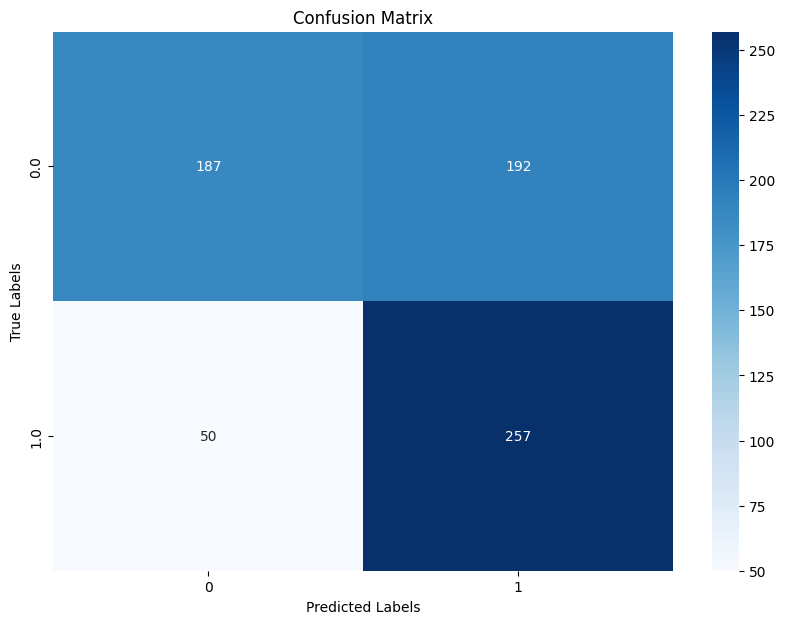

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the size of the figure
plt.figure(figsize=(10, 7))

# Create a heatmap from the confusion matrix
confusion_matrix = pd.crosstab(test_all_merged_labels, test_preds_all_model)
sns.heatmap(confusion_matrix,
            annot=True,
            fmt='d',
            cmap='Blues',
            cbar=True)

# Set titles and labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Show the plot
plt.show()

---
---

# Bimodal

## Text and Audio

In [40]:
train_text_audio_merged_labels = train_text_audio_merged_df['annotation_label']
train_text_audio_merged_features = train_text_audio_merged_df.drop(columns=['video_id', 'clip_id', 'annotation_label'])
train_text_audio_merged_features = train_text_audio_merged_features.values.tolist()
# Create datasets with the features and labels
train_text_audio_merged_dataset = Dataset.from_dict({
    'input_ids': train_text_audio_merged_features,
    'labels': train_text_audio_merged_labels.tolist(),
    'clip_id': train_text_audio_merged_df['clip_id'].tolist(),
    'video_id': train_text_audio_merged_df['video_id'].tolist()
})

valid_text_audio_merged_labels = valid_text_audio_merged_df['annotation_label']
valid_text_audio_merged_features = valid_text_audio_merged_df.drop(columns=['video_id', 'clip_id', 'annotation_label'])
valid_text_audio_merged_features = valid_text_audio_merged_features.values.tolist()
# Create datasets with the features and labels
valid_text_audio_merged_dataset = Dataset.from_dict({
    'input_ids': valid_text_audio_merged_features,
    'labels': valid_text_audio_merged_labels.tolist(),
    'clip_id': valid_text_audio_merged_df['clip_id'].tolist(),
    'video_id': valid_text_audio_merged_df['video_id'].tolist()
})

test_text_audio_merged_labels = test_text_audio_merged_df['annotation_label']
test_text_audio_merged_features = test_text_audio_merged_df.drop(columns=['video_id', 'clip_id', 'annotation_label'])
test_text_audio_merged_features = test_text_audio_merged_features.values.tolist()
# Create datasets with the features and labels
test_text_audio_merged_dataset = Dataset.from_dict({
    'input_ids': test_text_audio_merged_features,
    'labels': test_text_audio_merged_labels.tolist(),
    'clip_id': test_text_audio_merged_df['clip_id'].tolist(),
    'video_id': test_text_audio_merged_df['video_id'].tolist()
})

# Create the DatasetDict to hold the subsets
dataset_text_audio_merged = DatasetDict({
    'train': train_text_audio_merged_dataset,
    'valid': valid_text_audio_merged_dataset,
    'test': test_text_audio_merged_dataset
})

In [41]:
# Convert datasets to DataLoaders
train_text_audio_loader = DataLoader(dataset_text_audio_merged['train'], batch_size=128, shuffle=True, collate_fn=collate_fn)
valid_text_audio_loader = DataLoader(dataset_text_audio_merged['valid'], batch_size=128, shuffle=False, collate_fn=collate_fn)
test_text_audio_loader = DataLoader(dataset_text_audio_merged['test'], batch_size=1, shuffle=False, collate_fn=collate_fn)

In [42]:
# Initialize the model
layer_sizes_text_audio = [1024, 32]
dropout_p_text_audio = 0.3
text_audio_model = MLP_Model(layer_sizes=layer_sizes_text_audio, dropout_p=dropout_p_text_audio, act_func="relu")

# Move the model to the appropriate device (GPU if available)
text_audio_model.to(device)

# Define the loss function and optimizer
text_audio_criterion = nn.CrossEntropyLoss()  # Suitable for classification tasks
text_audio_optimizer = optim.AdamW(text_audio_model.parameters(), lr=5e-6, weight_decay=1e-4)

In [ ]:
# import itertools
# import torch.optim as optim
# def grid_search(layer_size_options, dropout_options, act_func_options, batch_options, lr_options, weightdecay_options,
#                 train_set, valid_set,
#                 device,
#                 max_epochs=15):
#     best_model = None
#     best_valid_accuracy = 0.0
#     best_params = None
#     best_epoch = 0

#     param_combinations = list(itertools.product(layer_size_options, dropout_options, act_func_options, batch_options, lr_options, weightdecay_options))

#     model_versions = []  # Store the best model for each hyperparameter combination

#     for layer_sizes, dropout_p, act_func, batch_size, lr, wd in param_combinations:
#         print(f"Testing configuration: layer_sizes={layer_sizes}, dropout_p={dropout_p}, act_func={act_func}, batch_size={batch_size} , lr={lr}, wd={wd}")

#         train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
#         valid_loader = DataLoader(valid_set, batch_size=128, shuffle=False, collate_fn=collate_fn)

#         # Initialize the model
#         model = MLP_Model(layer_sizes=layer_sizes, dropout_p=dropout_p, act_func=act_func)
#         model.to(device)

#         criterion = nn.CrossEntropyLoss()

#         # Define optimizer
#         optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

#         best_loss_for_config = float('inf')
#         best_accuracy_for_config = 0.0
#         best_epoch_for_config = 0
#         best_model_for_config = None

#         for epoch in range(max_epochs):
#             # print(f'Epoch {epoch + 1} / {max_epochs}')
#             train_loss, _, _, _ = train(model, train_loader, criterion, optimizer)
#             valid_loss, valid_accuracy, _, _ = evaluate(model, valid_loader, criterion, optimizer)

#             # print(f'Validation Loss: {valid_loss:.3f}, Validation Accuracy: {valid_accuracy:.3f}')

#             if valid_loss < best_loss_for_config:
#                 best_loss_for_config = valid_loss
#                 best_accuracy_for_config = valid_accuracy
#                 best_epoch_for_config = epoch + 1
#                 best_model_for_config = model
#                 torch.save(model.state_dict(), f'model_config_{layer_sizes}_{dropout_p}_{act_func}_best.bin')

#         model_versions.append((best_accuracy_for_config, best_loss_for_config, best_model_for_config, layer_sizes, dropout_p, act_func, best_epoch_for_config))

#     # Select the best model: highest accuracy among the best-loss models
#     model_versions.sort(key=lambda x: -x[0])  # Sort by accuracy (descending)
#     best_valid_accuracy, best_valid_loss, best_model, best_layer_sizes, best_dropout_p, best_act_func, best_epoch = model_versions[0]

#     print(f'Best Configuration: layer_sizes={best_layer_sizes}, dropout_p={best_dropout_p}, act_func={best_act_func}')
#     print(f'Best Validation Loss: {best_valid_loss:.3f}, Best Validation Accuracy: {best_valid_accuracy:.3f}, Best Epoch: {best_epoch}')

#     return best_model, (best_layer_sizes, best_dropout_p, best_act_func)

# # Define parameter search space
# layer_sizes_options = [[1024, 1024],
#                        [1024, 512],
#                        [1024, 256],
#                        [1024, 128],
#                        [1024, 32],
#                        [1024, 1024, 512],
#                        [1024, 1024, 256],
#                        [1024, 1024, 128],
#                        [1024, 1024, 32],
#                        [1024, 512, 256],
#                        [1024, 512, 128],
#                        [1024, 512, 32],
#                        [1024, 1024, 512, 256],
#                        [1024, 1024, 512, 128],
#                        [1024, 1024, 512, 32],
#                        [1024, 512, 256, 128],
#                        [1024, 512, 256, 32],
#                        [1024, 512, 128, 32],
#                        [1024, 1024, 512, 256, 128],
#                        [1024, 1024, 512, 256, 32],
#                        [1024, 1024, 512, 128, 32],
#                        [1024, 512, 256, 128, 64],
#                        [1024, 512, 256, 128, 32]]
# batch_options = [16, 32, 64, 128, 256]
# lr_options = [5e-5, 1e-5, 5e-6]
# weightdecay_options = [1e-3, 1e-4, 1e-5]
# dropout_options = [0.1, 0.3, 0.5]
# act_func_options = ["tanh", "relu"]

# # Run grid search
# best_model, best_params = grid_search(
#     layer_sizes_options, dropout_options, act_func_options, batch_options, lr_options, weightdecay_options,
#     dataset_text_audio_merged['train'], dataset_text_audio_merged['valid'],
#     device
# )

In [70]:
# # Main training loop
# epochs_text_audio_model = 15

# train_losses_text_audio_model, valid_losses_text_audio_model = [], []
# best_valid_loss_text_audio_model = float('inf')
# best_valid_loss_epoch_text_audio_model = 0

# for epoch in range(epochs_text_audio_model):
#     print(f'\n Epoch {epoch + 1} / {epochs_text_audio_model}')

#     # Training step
#     train_loss_text_audio_model, _, _, _ = train(text_audio_model, train_text_audio_loader, text_audio_criterion, text_audio_optimizer)
#     train_losses_text_audio_model.append(train_loss_text_audio_model)

#     # Validation step (optional)
#     valid_loss_text_audio_model, _, _, _, _  = evaluate(text_audio_model, valid_text_audio_loader, text_audio_criterion, text_audio_optimizer)
#     valid_losses_text_audio_model.append(valid_loss_text_audio_model)

#     print(f'Training Loss: {train_loss_text_audio_model:.3f}')
#     print(f'Validation Loss: {valid_loss_text_audio_model:.3f}')

#     # Save the model if it has the best validation loss so far
#     if valid_loss_text_audio_model <= best_valid_loss_text_audio_model:   # If we find one with the same, keep the one with the biggest epoch
#         best_valid_loss_text_audio_model = valid_loss_text_audio_model
#         best_valid_loss_epoch_text_audio_model = epoch + 1
#         torch.save(text_audio_model.state_dict(), 'MLP_ealyFusion_text_audio_model_best_model_state.bin')


 Epoch 1 / 15
Training Loss: 0.696
Validation Loss: 0.625

 Epoch 2 / 15
Training Loss: 0.687
Validation Loss: 0.623

 Epoch 3 / 15
Training Loss: 0.701
Validation Loss: 0.621

 Epoch 4 / 15
Training Loss: 0.694
Validation Loss: 0.621

 Epoch 5 / 15
Training Loss: 0.693
Validation Loss: 0.622

 Epoch 6 / 15
Training Loss: 0.686
Validation Loss: 0.624

 Epoch 7 / 15
Training Loss: 0.690
Validation Loss: 0.625

 Epoch 8 / 15
Training Loss: 0.691
Validation Loss: 0.626

 Epoch 9 / 15
Training Loss: 0.687
Validation Loss: 0.628

 Epoch 10 / 15
Training Loss: 0.692
Validation Loss: 0.632

 Epoch 11 / 15
Training Loss: 0.676
Validation Loss: 0.635

 Epoch 12 / 15
Training Loss: 0.673
Validation Loss: 0.637

 Epoch 13 / 15
Training Loss: 0.675
Validation Loss: 0.636

 Epoch 14 / 15
Training Loss: 0.676
Validation Loss: 0.632

 Epoch 15 / 15
Training Loss: 0.673
Validation Loss: 0.630


In [71]:
print("Optimal epoch: ", best_valid_loss_epoch_text_audio_model)

Optimal epoch:  4


In [43]:
# Initialize a model and move it to GPU
text_audio_model_opt = MLP_Model(layer_sizes=layer_sizes_text_audio, dropout_p=dropout_p_text_audio)
text_audio_model_opt = text_audio_model_opt.to(device)

# Load
text_audio_model_opt.load_state_dict(torch.load('MLP_ealyFusion_text_audio_model_best_model_state.bin'))      # Load the saved state dictionary
text_audio_model_opt.eval()                                                                # Set the model to evaluation mode

/tmp/ipykernel_557354/2246518797.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  text_audio_model_opt.load_state_dict(torch.load('MLP_ealyFusion_text_audio_model_best_mo

MLP_Model(
  (layers): ModuleList(
    (0): Linear(in_features=1024, out_features=32, bias=True)
  )
  (out): Linear(in_features=32, out_features=2, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (act): Tanh()
)

In [44]:
# Assuming you have already created test_dataloader
test_avg_loss_text_audio_model, _, test_preds_text_audio_model, _ , test_outputs_text_audio_model, test_video_ids_text_audio_model, test_clip_ids_text_audio_model  = evaluate(text_audio_model_opt, test_text_audio_loader, text_audio_criterion, text_audio_optimizer, track_clipVideo_id=True)

# Print the results
print(f'Average Loss: {test_avg_loss_text_audio_model:.4f}')

/tmp/ipykernel_557354/2779074390.py:6: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  labels = torch.tensor([item['labels'] for item in batch], dtype=torch.long)


Average Loss: 0.5946


In [45]:
# Apply softmax
test_outputs_text_audio_model = torch.tensor(test_outputs_text_audio_model)  # Convert to tensor
test_text_audio_probabilities = torch.nn.functional.softmax(test_outputs_text_audio_model, dim=1).cpu().numpy()  # Compute probabilities

In [46]:
test_text_audio_probabilities

array([[0.5314093 , 0.46859065],
       [0.34380442, 0.65619564],
       [0.5437573 , 0.45624265],
       ...,
       [0.34493247, 0.65506756],
       [0.4818356 , 0.51816434],
       [0.36118698, 0.638813  ]], dtype=float32)

In [50]:
# Create a DataFrame with the required information
text_audio_test_results_df = pd.DataFrame({
    'video_id': test_video_ids_text_audio_model,
    'clip_id': test_clip_ids_text_audio_model,
    'annotation_label': test_text_audio_merged_labels,
    'text_audio_prob_0': test_text_audio_probabilities[:, 0],  # Probability of class 0
    'text_audio_prob_1': test_text_audio_probabilities[:, 1],   # Probability of class 1
    'text_audio_preds': test_preds_text_audio_model,
})

In [51]:
text_audio_test_results_df

,video_id,clip_id,annotation_label,text_audio_prob_0,text_audio_prob_1,text_audio_preds
1513,c7UH_rxdZv4,24,0.0,0.531409,0.468591,0
1514,c7UH_rxdZv4,25,1.0,0.343804,0.656196,1
1515,c7UH_rxdZv4,26,0.0,0.543757,0.456243,0
1516,c7UH_rxdZv4,27,0.0,0.563868,0.436132,0
1517,c7UH_rxdZv4,20,0.0,0.563983,0.436017,0
...,...,...,...,...,...,...
2194,zhpQhgha_KU,30,0.0,0.559317,0.440684,0
2195,zhpQhgha_KU,35,1.0,0.334322,0.665678,1
2196,zhpQhgha_KU,34,1.0,0.344932,0.655068,1
2197,zhpQhgha_KU,33,0.0,0.481836,0.518164,1


In [53]:
# Calculate accuracy
accuracy = (text_audio_test_results_df['annotation_label'] == text_audio_test_results_df['text_audio_preds']).mean()
print(f"Accuracy: {accuracy}")

Accuracy: 0.8367346938775511


In [54]:
valid_avg_loss_text_audio_model, _, valid_preds_text_audio_model, _ , valid_outputs_text_audio_model, valid_video_ids_text_audio_model, valid_clip_ids_text_audio_model  = evaluate(text_audio_model_opt, valid_text_audio_loader, text_audio_criterion, text_audio_optimizer, track_clipVideo_id=True)
# Apply softmax
valid_outputs_text_audio_model = torch.tensor(valid_outputs_text_audio_model)  # Convert to tensor
valid_text_audio_probabilities = torch.nn.functional.softmax(valid_outputs_text_audio_model, dim=1).cpu().numpy()  # Compute probabilities
# Create a DataFrame with the required information
text_audio_valid_results_df = pd.DataFrame({
    'video_id': valid_video_ids_text_audio_model,
    'clip_id': valid_clip_ids_text_audio_model,
    'annotation_label': valid_text_audio_merged_labels,
    'text_audio_prob_0': valid_text_audio_probabilities[:, 0],  # Probability of class 0
    'text_audio_prob_1': valid_text_audio_probabilities[:, 1],   # Probability of class 1
    'text_audio_preds': valid_preds_text_audio_model,
})

trainSerial_text_audio_loader = DataLoader(dataset_text_audio_merged['train'], batch_size=32, shuffle=False, collate_fn=collate_fn)
train_avg_loss_text_audio_model, _, train_preds_text_audio_model, _ , train_outputs_text_audio_model, train_video_ids_text_audio_model, train_clip_ids_text_audio_model  = evaluate(text_audio_model_opt, trainSerial_text_audio_loader, text_audio_criterion, text_audio_optimizer, track_clipVideo_id=True)
# Apply softmax
train_outputs_text_audio_model = torch.tensor(train_outputs_text_audio_model)  # Convert to tensor
train_text_audio_probabilities = torch.nn.functional.softmax(train_outputs_text_audio_model, dim=1).cpu().numpy()  # Compute probabilities
# Create a DataFrame with the required information
text_audio_train_results_df = pd.DataFrame({
    'video_id': train_video_ids_text_audio_model,
    'clip_id': train_clip_ids_text_audio_model,
    'annotation_label': train_text_audio_merged_labels,
    'text_audio_prob_0': train_text_audio_probabilities[:, 0],  # Probability of class 0
    'text_audio_prob_1': train_text_audio_probabilities[:, 1],   # Probability of class 1
    'text_audio_preds': train_preds_text_audio_model,
})

/tmp/ipykernel_557354/2779074390.py:6: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  labels = torch.tensor([item['labels'] for item in batch], dtype=torch.long)


In [56]:
text_audio_results_df = pd.concat([text_audio_train_results_df, text_audio_valid_results_df, text_audio_test_results_df], ignore_index=True)

In [57]:
text_audio_results_df

,video_id,clip_id,annotation_label,text_audio_prob_0,text_audio_prob_1,text_audio_preds
0,03bSnISJMiM,11,0.0,0.545542,0.454458,0
1,03bSnISJMiM,10,0.0,0.546001,0.453999,0
2,03bSnISJMiM,13,1.0,0.354512,0.645488,1
3,03bSnISJMiM,12,1.0,0.349426,0.650574,1
4,03bSnISJMiM,1,1.0,0.516387,0.483613,0
...,...,...,...,...,...,...
2194,zhpQhgha_KU,30,0.0,0.559317,0.440684,0
2195,zhpQhgha_KU,35,1.0,0.334322,0.665678,1
2196,zhpQhgha_KU,34,1.0,0.344932,0.655068,1
2197,zhpQhgha_KU,33,0.0,0.481836,0.518164,1


In [58]:
columns_to_check = ['video_id', 'clip_id', 'annotation_label']
match1 = (text_audio_results_df[columns_to_check] == df1[columns_to_check]).all().all()

print(f"Do the columns match? {match1}")

match2 = text_audio_results_df[columns_to_check].equals(df1[columns_to_check])

print(f"Do the columns match? {match2}")

Do the columns match? True
Do the columns match? True


In [59]:
print(classification_report(test_text_audio_merged_labels, test_preds_text_audio_model, digits=4))

              precision    recall  f1-score   support

         0.0     0.8719    0.8259    0.8482       379
         1.0     0.7982    0.8502    0.8233       307

    accuracy                         0.8367       686
   macro avg     0.8350    0.8380    0.8358       686
weighted avg     0.8389    0.8367    0.8371       686



---
## Text and Video

In [60]:
train_text_video_merged_labels = train_text_video_merged_df['annotation_label']
train_text_video_merged_features = train_text_video_merged_df.drop(columns=['video_id', 'clip_id', 'annotation_label'])
train_text_video_merged_features = train_text_video_merged_features.values.tolist()
# Create datasets with the features and labels
train_text_video_merged_dataset = Dataset.from_dict({
    'input_ids': train_text_video_merged_features,
    'labels': train_text_video_merged_labels.tolist(),
    'clip_id': train_text_video_merged_df['clip_id'].tolist(),
    'video_id': train_text_video_merged_df['video_id'].tolist()
})

valid_text_video_merged_labels = valid_text_video_merged_df['annotation_label']
valid_text_video_merged_features = valid_text_video_merged_df.drop(columns=['video_id', 'clip_id', 'annotation_label'])
valid_text_video_merged_features = valid_text_video_merged_features.values.tolist()
# Create datasets with the features and labels
valid_text_video_merged_dataset = Dataset.from_dict({
    'input_ids': valid_text_video_merged_features,
    'labels': valid_text_video_merged_labels.tolist(),
    'clip_id': valid_text_video_merged_df['clip_id'].tolist(),
    'video_id': valid_text_video_merged_df['video_id'].tolist()
})

test_text_video_merged_labels = test_text_video_merged_df['annotation_label']
test_text_video_merged_features = test_text_video_merged_df.drop(columns=['video_id', 'clip_id', 'annotation_label'])
test_text_video_merged_features = test_text_video_merged_features.values.tolist()
# Create datasets with the features and labels
test_text_video_merged_dataset = Dataset.from_dict({
    'input_ids': test_text_video_merged_features,
    'labels': test_text_video_merged_labels.tolist(),
    'clip_id': test_text_video_merged_df['clip_id'].tolist(),
    'video_id': test_text_video_merged_df['video_id'].tolist()
})

# Create the DatasetDict to hold the subsets
dataset_text_video_merged = DatasetDict({
    'train': train_text_video_merged_dataset,
    'valid': valid_text_video_merged_dataset,
    'test': test_text_video_merged_dataset
})

In [61]:
# Convert datasets to DataLoaders
train_text_video_loader = DataLoader(dataset_text_video_merged['train'], batch_size=128, shuffle=True, collate_fn=collate_fn)
valid_text_video_loader = DataLoader(dataset_text_video_merged['valid'], batch_size=128, shuffle=False, collate_fn=collate_fn)
test_text_video_loader = DataLoader(dataset_text_video_merged['test'], batch_size=128, shuffle=False, collate_fn=collate_fn)

In [62]:
# Initialize the model
layer_sizes_text_video = [(768+768), 256]
dropout_p_text_video = 0.1
text_video_model = MLP_Model(layer_sizes=layer_sizes_text_video, dropout_p=dropout_p_text_video, act_func="relu")

# Move the model to the appropriate device (GPU if available)
text_video_model.to(device)

# Define the loss function and optimizer
text_video_criterion = nn.CrossEntropyLoss()  # Suitable for classification tasks
text_video_optimizer = optim.AdamW(text_video_model.parameters(), lr=5e-6, weight_decay=1e-4)

In [78]:
# # Main training loop
# epochs_text_video_model = 15

# train_losses_text_video_model, valid_losses_text_video_model = [], []
# best_valid_loss_text_video_model = float('inf')
# best_valid_loss_epoch_text_video_model = 0

# for epoch in range(epochs_text_video_model):
#     print(f'\n Epoch {epoch + 1} / {epochs_text_video_model}')

#     # Training step
#     train_loss_text_video_model, _, _, _ = train(text_video_model, train_text_video_loader, text_video_criterion, text_video_optimizer)
#     train_losses_text_video_model.append(train_loss_text_video_model)

#     # Validation step (optional)
#     valid_loss_text_video_model, _, _, _, _  = evaluate(text_video_model, valid_text_video_loader, text_video_criterion, text_video_optimizer)
#     valid_losses_text_video_model.append(valid_loss_text_video_model)

#     print(f'Training Loss: {train_loss_text_video_model:.3f}')
#     print(f'Validation Loss: {valid_loss_text_video_model:.3f}')

#     # Save the model if it has the best validation loss so far
#     if valid_loss_text_video_model <= best_valid_loss_text_video_model:   # If we find one with the same, keep the one with the biggest epoch
#         best_valid_loss_text_video_model = valid_loss_text_video_model
#         best_valid_loss_epoch_text_video_model = epoch + 1
#         torch.save(text_video_model.state_dict(), 'MLP_ealyFusion_text_video_model_best_model_state.bin')


 Epoch 1 / 10
Training Loss: 0.684
Validation Loss: 0.641

 Epoch 2 / 10
Training Loss: 0.677
Validation Loss: 0.648

 Epoch 3 / 10
Training Loss: 0.676
Validation Loss: 0.657

 Epoch 4 / 10
Training Loss: 0.692
Validation Loss: 0.650

 Epoch 5 / 10
Training Loss: 0.669
Validation Loss: 0.661

 Epoch 6 / 10
Training Loss: 0.665
Validation Loss: 0.658

 Epoch 7 / 10
Training Loss: 0.659
Validation Loss: 0.651

 Epoch 8 / 10
Training Loss: 0.678
Validation Loss: 0.651

 Epoch 9 / 10
Training Loss: 0.667
Validation Loss: 0.656

 Epoch 10 / 10
Training Loss: 0.649
Validation Loss: 0.656


In [63]:
# Initialize a model and move it to GPU
text_video_model_opt = MLP_Model(layer_sizes=layer_sizes_text_video, dropout_p=dropout_p_text_video)
text_video_model_opt = text_video_model_opt.to(device)

# Load
text_video_model_opt.load_state_dict(torch.load('MLP_ealyFusion_text_video_model_best_model_state.bin'))      # Load the saved state dictionary
text_video_model_opt.eval()                                                                                    # Set the model to evaluation mode

/tmp/ipykernel_557354/3629736115.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  text_video_model_opt.load_state_dict(torch.load('MLP_ealyFusion_text_video_model_best_mo

MLP_Model(
  (layers): ModuleList(
    (0): Linear(in_features=1536, out_features=256, bias=True)
  )
  (out): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (act): Tanh()
)

In [64]:
# Assuming you have already created test_dataloader
test_avg_loss_text_video_model, _, test_preds_text_video_model, _ , test_outputs_text_video_model, test_video_ids_text_video_model, test_clip_ids_text_video_model  = evaluate(text_video_model_opt, test_text_video_loader, text_video_criterion, text_video_optimizer, track_clipVideo_id=True)

# Print the results
print(f'Average Loss: {test_avg_loss_text_video_model:.4f}')

/tmp/ipykernel_557354/2779074390.py:6: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  labels = torch.tensor([item['labels'] for item in batch], dtype=torch.long)


Average Loss: 0.5870


In [65]:
# Apply softmax
test_outputs_text_video_model = torch.tensor(test_outputs_text_video_model)  # Convert to tensor
test_text_video_probabilities = torch.nn.functional.softmax(test_outputs_text_video_model, dim=1).cpu().numpy()  # Compute probabilities

In [66]:
test_text_video_probabilities

array([[0.57492566, 0.42507434],
       [0.40531382, 0.59468615],
       [0.5453139 , 0.45468608],
       ...,
       [0.38617435, 0.61382556],
       [0.5240288 , 0.47597125],
       [0.37103295, 0.62896705]], dtype=float32)

In [68]:
# Create a DataFrame with the required information
text_video_test_results_df = pd.DataFrame({
    'video_id': test_video_ids_text_video_model,
    'clip_id': test_clip_ids_text_video_model,
    'annotation_label': test_text_video_merged_labels,
    'text_video_prob_0': test_text_video_probabilities[:, 0],  # Probability of class 0
    'text_video_prob_1': test_text_video_probabilities[:, 1],   # Probability of class 1
    'text_video_preds': test_preds_text_video_model,
})

In [69]:
# Calculate accuracy
accuracy = (text_video_test_results_df['annotation_label'] == text_video_test_results_df['text_video_preds']).mean()
print(f"Accuracy: {accuracy}")

Accuracy: 0.8119533527696793


In [70]:
valid_avg_loss_text_video_model, _, valid_preds_text_video_model, _ , valid_outputs_text_video_model, valid_video_ids_text_video_model, valid_clip_ids_text_video_model  = evaluate(text_video_model_opt, valid_text_video_loader, text_video_criterion, text_video_optimizer, track_clipVideo_id=True)
# Apply softmax
valid_outputs_text_video_model = torch.tensor(valid_outputs_text_video_model)  # Convert to tensor
valid_text_video_probabilities = torch.nn.functional.softmax(valid_outputs_text_video_model, dim=1).cpu().numpy()  # Compute probabilities
# Create a DataFrame with the required information
text_video_valid_results_df = pd.DataFrame({
    'video_id': valid_video_ids_text_video_model,
    'clip_id': valid_clip_ids_text_video_model,
    'annotation_label': valid_text_video_merged_labels,
    'text_video_prob_0': valid_text_video_probabilities[:, 0],  # Probability of class 0
    'text_video_prob_1': valid_text_video_probabilities[:, 1],   # Probability of class 1
    'text_video_preds': valid_preds_text_video_model,
})

trainSerial_text_video_loader = DataLoader(dataset_text_video_merged['train'], batch_size=32, shuffle=False, collate_fn=collate_fn)
train_avg_loss_text_video_model, _, train_preds_text_video_model, _ , train_outputs_text_video_model, train_video_ids_text_video_model, train_clip_ids_text_video_model  = evaluate(text_video_model_opt, trainSerial_text_video_loader, text_video_criterion, text_video_optimizer, track_clipVideo_id=True)
# Apply softmax
train_outputs_text_video_model = torch.tensor(train_outputs_text_video_model)  # Convert to tensor
train_text_video_probabilities = torch.nn.functional.softmax(train_outputs_text_video_model, dim=1).cpu().numpy()  # Compute probabilities
# Create a DataFrame with the required information
text_video_train_results_df = pd.DataFrame({
    'video_id': train_video_ids_text_video_model,
    'clip_id': train_clip_ids_text_video_model,
    'annotation_label': train_text_video_merged_labels,
    'text_video_prob_0': train_text_video_probabilities[:, 0],  # Probability of class 0
    'text_video_prob_1': train_text_video_probabilities[:, 1],   # Probability of class 1
    'text_video_preds': train_preds_text_video_model,
})

/tmp/ipykernel_557354/2779074390.py:6: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  labels = torch.tensor([item['labels'] for item in batch], dtype=torch.long)


In [74]:
text_video_results_df = pd.concat([text_video_train_results_df, text_video_valid_results_df, text_video_test_results_df], ignore_index=True)

In [73]:
columns_to_check = ['video_id', 'clip_id', 'annotation_label']
match1 = (text_video_results_df[columns_to_check] == df1[columns_to_check]).all().all()

print(f"Do the columns match? {match1}")

match2 = text_video_results_df[columns_to_check].equals(df1[columns_to_check])

print(f"Do the columns match? {match2}")

Do the columns match? True
Do the columns match? True


In [71]:
print(classification_report(test_text_video_merged_labels, test_preds_text_video_model, digits=4))

              precision    recall  f1-score   support

         0.0     0.7976    0.8839    0.8385       379
         1.0     0.8346    0.7231    0.7749       307

    accuracy                         0.8120       686
   macro avg     0.8161    0.8035    0.8067       686
weighted avg     0.8142    0.8120    0.8101       686



---
## Audio and Video

In [75]:
train_audio_video_merged_labels = train_audio_video_merged_df['annotation_label']
train_audio_video_merged_features = train_audio_video_merged_df.drop(columns=['video_id', 'clip_id', 'annotation_label'])
train_audio_video_merged_features = train_audio_video_merged_features.values.tolist()
# Create datasets with the features and labels
train_audio_video_merged_dataset = Dataset.from_dict({
    'input_ids': train_audio_video_merged_features,
    'labels': train_audio_video_merged_labels.tolist(),
    'clip_id': train_audio_video_merged_df['clip_id'].tolist(),
    'video_id': train_audio_video_merged_df['video_id'].tolist()
})

valid_audio_video_merged_labels = valid_audio_video_merged_df['annotation_label']
valid_audio_video_merged_features = valid_audio_video_merged_df.drop(columns=['video_id', 'clip_id', 'annotation_label'])
valid_audio_video_merged_features = valid_audio_video_merged_features.values.tolist()
# Create datasets with the features and labels
valid_audio_video_merged_dataset = Dataset.from_dict({
    'input_ids': valid_audio_video_merged_features,
    'labels': valid_audio_video_merged_labels.tolist(),
    'clip_id': valid_audio_video_merged_df['clip_id'].tolist(),
    'video_id': valid_audio_video_merged_df['video_id'].tolist()
})

test_audio_video_merged_labels = test_audio_video_merged_df['annotation_label']
test_audio_video_merged_features = test_audio_video_merged_df.drop(columns=['video_id', 'clip_id', 'annotation_label'])
test_audio_video_merged_features = test_audio_video_merged_features.values.tolist()
# Create datasets with the features and labels
test_audio_video_merged_dataset = Dataset.from_dict({
    'input_ids': test_audio_video_merged_features,
    'labels': test_audio_video_merged_labels.tolist(),
    'clip_id': test_audio_video_merged_df['clip_id'].tolist(),
    'video_id': test_audio_video_merged_df['video_id'].tolist()
})

# Create the DatasetDict to hold the subsets
dataset_audio_video_merged = DatasetDict({
    'train': train_audio_video_merged_dataset,
    'valid': valid_audio_video_merged_dataset,
    'test': test_audio_video_merged_dataset
})

In [76]:
# Convert datasets to DataLoaders
train_audio_video_loader = DataLoader(dataset_audio_video_merged['train'], batch_size=128, shuffle=True, collate_fn=collate_fn)
valid_audio_video_loader = DataLoader(dataset_audio_video_merged['valid'], batch_size=128, shuffle=False, collate_fn=collate_fn)
test_audio_video_loader = DataLoader(dataset_audio_video_merged['test'], batch_size=128, shuffle=False, collate_fn=collate_fn)

In [77]:
# Initialize the model
layer_sizes_audio_video = [(768+256), 128, 128]
dropout_p_audio_video = 0.1
audio_video_model = MLP_Model(layer_sizes=layer_sizes_audio_video, dropout_p=dropout_p_audio_video, act_func="tanh")

# Move the model to the appropriate device (GPU if available)
audio_video_model.to(device)

# Define the loss function and optimizer
audio_video_criterion = nn.CrossEntropyLoss()  # Suitable for classification tasks
audio_video_optimizer = optim.AdamW(audio_video_model.parameters(), lr=1e-5, weight_decay=1e-3)

In [78]:
# # Main training loop
# epochs_audio_video_model = 15

# train_losses_audio_video_model, valid_losses_audio_video_model = [], []
# best_valid_loss_audio_video_model = float('inf')
# best_valid_loss_epoch_audio_video_model = 0

# for epoch in range(epochs_audio_video_model):
#     print(f'\n Epoch {epoch + 1} / {epochs_audio_video_model}')

#     # Training step
#     train_loss_audio_video_model, _, _, _ = train(audio_video_model, train_audio_video_loader, audio_video_criterion, audio_video_optimizer)
#     train_losses_audio_video_model.append(train_loss_audio_video_model)

#     # Validation step (optional)
#     valid_loss_audio_video_model, _, _, _, _  = evaluate(audio_video_model, valid_audio_video_loader, audio_video_criterion, audio_video_optimizer)
#     valid_losses_audio_video_model.append(valid_loss_audio_video_model)

#     print(f'Training Loss: {train_loss_audio_video_model:.3f}')
#     print(f'Validation Loss: {valid_loss_audio_video_model:.3f}')

#     # Save the model if it has the best validation loss so far
#     if valid_loss_audio_video_model <= best_valid_loss_audio_video_model:   # If we find one with the same, keep the one with the biggest epoch
#         best_valid_loss_audio_video_model = valid_loss_audio_video_model
#         best_valid_loss_epoch_audio_video_model = epoch + 1
#         torch.save(audio_video_model.state_dict(), 'MLP_ealyFusion_audio_video_model_best_model_state.bin')

In [79]:
# Initialize a model and move it to GPU
audio_video_model_opt = MLP_Model(layer_sizes=layer_sizes_audio_video, dropout_p=dropout_p_audio_video)
audio_video_model_opt = audio_video_model_opt.to(device)

# Load
audio_video_model_opt.load_state_dict(torch.load('MLP_ealyFusion_audio_video_model_best_model_state.bin'))      # Load the saved state dictionary
audio_video_model_opt.eval()                                                                                    # Set the model to evaluation mode

/tmp/ipykernel_557354/4241706333.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  audio_video_model_opt.load_state_dict(torch.load('MLP_ealyFusion_audio_video_model_best_

MLP_Model(
  (layers): ModuleList(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
  )
  (out): Linear(in_features=128, out_features=2, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (act): Tanh()
)

In [80]:
# Assuming you have already created test_dataloader
test_avg_loss_audio_video_model, _, test_preds_audio_video_model, _ , test_outputs_audio_video_model, test_video_ids_audio_video_model, test_clip_ids_audio_video_model  = evaluate(audio_video_model_opt, test_audio_video_loader, audio_video_criterion, audio_video_optimizer, track_clipVideo_id=True)


# Print the results
print(f'Average Loss: {test_avg_loss_audio_video_model:.4f}')

/tmp/ipykernel_557354/2779074390.py:6: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  labels = torch.tensor([item['labels'] for item in batch], dtype=torch.long)


Average Loss: 0.6996


In [81]:
# Apply softmax
test_outputs_audio_video_model = torch.tensor(test_outputs_audio_video_model)  # Convert to tensor
test_audio_video_probabilities = torch.nn.functional.softmax(test_outputs_audio_video_model, dim=1).cpu().numpy()  # Compute probabilities

In [82]:
test_audio_video_probabilities

array([[0.38446894, 0.6155311 ],
       [0.3210413 , 0.6789587 ],
       [0.50379276, 0.49620727],
       ...,
       [0.35468748, 0.64531255],
       [0.4613342 , 0.5386659 ],
       [0.42548615, 0.57451385]], dtype=float32)

In [83]:
# Create a DataFrame with the required information
audio_video_test_results_df = pd.DataFrame({
    'video_id': test_video_ids_audio_video_model,
    'clip_id': test_clip_ids_audio_video_model,
    'annotation_label': test_audio_video_merged_labels,
    'audio_video_prob_0': test_audio_video_probabilities[:, 0],  # Probability of class 0
    'audio_video_prob_1': test_audio_video_probabilities[:, 1],   # Probability of class 1
    'audio_video_preds': test_preds_audio_video_model,
})

In [84]:
# Calculate accuracy
accuracy = (audio_video_test_results_df['annotation_label'] == audio_video_test_results_df['audio_video_preds']).mean()
print(f"Accuracy: {accuracy}")

Accuracy: 0.4970845481049563


In [85]:
valid_avg_loss_audio_video_model, _, valid_preds_audio_video_model, _ , valid_outputs_audio_video_model, valid_video_ids_audio_video_model, valid_clip_ids_audio_video_model  = evaluate(audio_video_model_opt, valid_audio_video_loader, audio_video_criterion, audio_video_optimizer, track_clipVideo_id=True)
# Apply softmax
valid_outputs_audio_video_model = torch.tensor(valid_outputs_audio_video_model)  # Convert to tensor
valid_audio_video_probabilities = torch.nn.functional.softmax(valid_outputs_audio_video_model, dim=1).cpu().numpy()  # Compute probabilities
# Create a DataFrame with the required information
audio_video_valid_results_df = pd.DataFrame({
    'video_id': valid_video_ids_audio_video_model,
    'clip_id': valid_clip_ids_audio_video_model,
    'annotation_label': valid_audio_video_merged_labels,
    'audio_video_prob_0': valid_audio_video_probabilities[:, 0],  # Probability of class 0
    'audio_video_prob_1': valid_audio_video_probabilities[:, 1],   # Probability of class 1
    'audio_video_preds': valid_preds_audio_video_model,
})

trainSerial_audio_video_loader = DataLoader(dataset_audio_video_merged['train'], batch_size=32, shuffle=False, collate_fn=collate_fn)
train_avg_loss_audio_video_model, _, train_preds_audio_video_model, _ , train_outputs_audio_video_model, train_video_ids_audio_video_model, train_clip_ids_audio_video_model  = evaluate(audio_video_model_opt, trainSerial_audio_video_loader, audio_video_criterion, audio_video_optimizer, track_clipVideo_id=True)
# Apply softmax
train_outputs_audio_video_model = torch.tensor(train_outputs_audio_video_model)  # Convert to tensor
train_audio_video_probabilities = torch.nn.functional.softmax(train_outputs_audio_video_model, dim=1).cpu().numpy()  # Compute probabilities
# Create a DataFrame with the required information
audio_video_train_results_df = pd.DataFrame({
    'video_id': train_video_ids_audio_video_model,
    'clip_id': train_clip_ids_audio_video_model,
    'annotation_label': train_audio_video_merged_labels,
    'audio_video_prob_0': train_audio_video_probabilities[:, 0],  # Probability of class 0
    'audio_video_prob_1': train_audio_video_probabilities[:, 1],   # Probability of class 1
    'audio_video_preds': train_preds_audio_video_model,
})

/tmp/ipykernel_557354/2779074390.py:6: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  labels = torch.tensor([item['labels'] for item in batch], dtype=torch.long)


In [86]:
audio_video_results_df = pd.concat([audio_video_train_results_df, audio_video_valid_results_df, audio_video_test_results_df], ignore_index=True)

In [87]:
columns_to_check = ['video_id', 'clip_id', 'annotation_label']
match1 = (audio_video_results_df[columns_to_check] == df1[columns_to_check]).all().all()

print(f"Do the columns match? {match1}")

match2 = audio_video_results_df[columns_to_check].equals(df1[columns_to_check])

print(f"Do the columns match? {match2}")

Do the columns match? True
Do the columns match? True


In [267]:
print(classification_report(test_audio_video_merged_labels, test_preds_audio_video_model, digits=4))

              precision    recall  f1-score   support

         0.0     0.6518    0.1926    0.2974       379
         1.0     0.4669    0.8730    0.6084       307

    accuracy                         0.4971       686
   macro avg     0.5593    0.5328    0.4529       686
weighted avg     0.5690    0.4971    0.4366       686



---
---
---

In [90]:
earlyFusion_results_df = trimodal_results_df.merge(
    text_audio_results_df, on=["video_id", "clip_id", "annotation_label"], how="inner"
).merge(
    audio_video_results_df, on=["video_id", "clip_id", "annotation_label"], how="inner"
).merge(
    text_video_results_df, on=["video_id", "clip_id", "annotation_label"], how="inner"
)

In [91]:
earlyFusion_results_df

,video_id,clip_id,annotation_label,trimodal_prob_0,trimodal_prob_1,trimodal_preds,text_audio_prob_0,text_audio_prob_1,text_audio_preds,audio_video_prob_0,audio_video_prob_1,audio_video_preds,text_video_prob_0,text_video_prob_1,text_video_preds
0,03bSnISJMiM,11,0.0,0.459776,0.540224,1,0.545542,0.454458,0,0.410912,0.589088,1,0.547833,0.452167,0
1,03bSnISJMiM,10,0.0,0.564226,0.435774,0,0.546001,0.453999,0,0.439674,0.560326,1,0.602740,0.397260,0
2,03bSnISJMiM,13,1.0,0.080895,0.919105,1,0.354512,0.645488,1,0.370054,0.629946,1,0.382594,0.617406,1
3,03bSnISJMiM,12,1.0,0.070363,0.929637,1,0.349426,0.650574,1,0.358518,0.641482,1,0.386552,0.613448,1
4,03bSnISJMiM,1,1.0,0.276498,0.723502,1,0.516387,0.483613,0,0.365942,0.634058,1,0.582906,0.417094,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2194,zhpQhgha_KU,30,0.0,0.916739,0.083261,0,0.559317,0.440684,0,0.546081,0.453919,0,0.542318,0.457682,0
2195,zhpQhgha_KU,35,1.0,0.329535,0.670465,1,0.334322,0.665678,1,0.398728,0.601272,1,0.396127,0.603873,1
2196,zhpQhgha_KU,34,1.0,0.093175,0.906825,1,0.344932,0.655068,1,0.354687,0.645313,1,0.386174,0.613826,1
2197,zhpQhgha_KU,33,0.0,0.379098,0.620902,1,0.481836,0.518164,1,0.461334,0.538666,1,0.524029,0.475971,0


In [92]:
earlyFusion_results_df.isna().any().any()

False

In [93]:
earlyFusion_results_df = earlyFusion_results_df.merge(
    all_merged_df[['video_id', 'clip_id', 'annotation_label', 'mode']], 
    on=['video_id', 'clip_id', 'annotation_label'], 
    how='inner'
)

In [94]:
earlyFusion_results_df

,video_id,clip_id,annotation_label,trimodal_prob_0,trimodal_prob_1,trimodal_preds,text_audio_prob_0,text_audio_prob_1,text_audio_preds,audio_video_prob_0,audio_video_prob_1,audio_video_preds,text_video_prob_0,text_video_prob_1,text_video_preds,mode
0,03bSnISJMiM,11,0.0,0.459776,0.540224,1,0.545542,0.454458,0,0.410912,0.589088,1,0.547833,0.452167,0,train
1,03bSnISJMiM,10,0.0,0.564226,0.435774,0,0.546001,0.453999,0,0.439674,0.560326,1,0.602740,0.397260,0,train
2,03bSnISJMiM,13,1.0,0.080895,0.919105,1,0.354512,0.645488,1,0.370054,0.629946,1,0.382594,0.617406,1,train
3,03bSnISJMiM,12,1.0,0.070363,0.929637,1,0.349426,0.650574,1,0.358518,0.641482,1,0.386552,0.613448,1,train
4,03bSnISJMiM,1,1.0,0.276498,0.723502,1,0.516387,0.483613,0,0.365942,0.634058,1,0.582906,0.417094,0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2194,zhpQhgha_KU,30,0.0,0.916739,0.083261,0,0.559317,0.440684,0,0.546081,0.453919,0,0.542318,0.457682,0,test
2195,zhpQhgha_KU,35,1.0,0.329535,0.670465,1,0.334322,0.665678,1,0.398728,0.601272,1,0.396127,0.603873,1,test
2196,zhpQhgha_KU,34,1.0,0.093175,0.906825,1,0.344932,0.655068,1,0.354687,0.645313,1,0.386174,0.613826,1,test
2197,zhpQhgha_KU,33,0.0,0.379098,0.620902,1,0.481836,0.518164,1,0.461334,0.538666,1,0.524029,0.475971,0,test


In [99]:
earlyFusion_results_df.isna().any().any()

False

In [104]:
# Filter the test set
temp = earlyFusion_results_df[earlyFusion_results_df['mode'] == 'test']

# Display results
temp_results = {
    'text_video_accuracy': (temp['text_video_preds'] == temp['annotation_label']).mean(),
    'text_audio_accuracy': (temp['text_audio_preds'] == temp['annotation_label']).mean(),
    'audio_video_accuracy': (temp['audio_video_preds'] == temp['annotation_label']).mean(),
    'trimodal_accuracy': (temp['trimodal_preds'] == temp['annotation_label']).mean()
}

print(temp_results)

{'text_video_accuracy': 0.8119533527696793, 'text_audio_accuracy': 0.8367346938775511, 'audio_video_accuracy': 0.4970845481049563, 'trimodal_accuracy': 0.6472303206997084}


In [100]:
earlyFusion_results_df.to_csv('earlyFusion_results_df.csv', index=False)